In [1]:
!pip install patchify

import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
np.random.seed(0) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
DATASET = 'MENDELEY'

if DATASET == 'MENDELEY':
    PATH = '/content/drive/MyDrive/AV_split/'
    TRAIN_PATH = PATH+'train/'
    TRAIN_IMAGE_PATH = TRAIN_PATH + 'images'
    TRAIN_MASK_PATH = TRAIN_PATH + 'GT_vessel'
    SIZE = 512
    
    TEST_PATH = PATH+'test/'
    TEST_IMAGE_PATH = TEST_PATH + 'images'
    TEST_MASK_PATH = TEST_PATH + 'GT_vessel'
    SAVE_TEST_IMAGE_PATH = TEST_PATH + 'predict'
    
elif DATASET == 'STARE':
    PATH = '/content/drive/MyDrive/STARE/'
    TRAIN_PATH = PATH+'train/'
    TRAIN_IMAGE_PATH = TRAIN_PATH + 'images'
    TRAIN_MASK_PATH = TRAIN_PATH + 'GT'
    SIZE = 512
    
    TEST_PATH = PATH+'test/'
    TEST_IMAGE_PATH = TEST_PATH + 'images'
    TEST_MASK_PATH = TEST_PATH + 'GT'
    SAVE_TEST_IMAGE_PATH = TEST_PATH + 'predict'

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)

    return imgs_equalized

def image_aug(image, patch_size):
    # av_split img shape 1000, 1504
    if DATASET == 'MENDELEY':
        image = image[70:970, 200:1255]

    image = image[:,:,1]
    image = clahe_equalized(image)

    SIZE_X = (image.shape[1]//patch_size)*patch_size 
    SIZE_Y = (image.shape[0]//patch_size)*patch_size     
    image = cv2.resize(image, (SIZE_X, SIZE_Y))
    image = np.array(image) 

    image = image / 255.

    return image

def mask_aug(mask, patch_size):
    thresh = 128
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]

    # av_split img shape 1000, 1504
    if DATASET == 'MENDELEY':
        mask = 255 - mask
        mask = mask[70:970, 200:1255]

    SIZE_X = (mask.shape[1]//patch_size)*patch_size
    SIZE_Y = (mask.shape[0]//patch_size)*patch_size     
    mask = cv2.resize(mask, (SIZE_X, SIZE_Y)) 
    mask = np.array(mask)
    
    mask = mask / 255.

    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return mask

In [5]:
image_dataset = []
mask_dataset = [] 

patch_size = 512

images = sorted(os.listdir(TRAIN_IMAGE_PATH)) 
for i, image_name in enumerate(images):  
   if image_name.endswith(".JPG"):                   
       image = cv2.imread(TRAIN_IMAGE_PATH + "/" + image_name)
       image = image_aug(image, patch_size)
       patches_img = patchify(image, (patch_size, patch_size), step=patch_size) 
            
       for i in range(patches_img.shape[0]):
           for j in range(patches_img.shape[1]):                        
               single_patch_img = patches_img[i,j,:,:]                
               single_patch_img = (single_patch_img.astype('float32'))              
               image_dataset.append(single_patch_img)

masks = sorted(os.listdir(TRAIN_MASK_PATH))  
for i, mask_name in enumerate(masks):  
    if mask_name.endswith(".jpg"):                 
        mask = cv2.imread(TRAIN_MASK_PATH + "/" + mask_name, cv2.IMREAD_GRAYSCALE)
        mask = mask_aug(mask, patch_size)
        patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size) 
            
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):                            
                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = (single_patch_mask.astype('float32'))
                mask_dataset.append(single_patch_mask)

In [6]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset = np.expand_dims(image_dataset,axis=-1)
mask_dataset =  np.expand_dims(mask_dataset,axis=-1)

In [7]:
print(image_dataset.shape, mask_dataset.shape)
print(image_dataset.max(), mask_dataset.max())
print(image_dataset.min(), mask_dataset.min())

(50, 512, 512, 1) (50, 512, 512, 1)
1.0 1.0
0.003921569 0.0


In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)

In [9]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = IoU_loss, metrics = ['accuracy', IoU_coef])
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [10]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.3, random_state=0)

In [12]:
#train model
history = model.fit(x_train, y_train, 
                    verbose = 1,
                    batch_size = 3,
                    validation_data = (x_test, y_test ), 
                    shuffle = False,
                    epochs = 150,
                    steps_per_epoch = 10)

Epoch 1/150
10/10 [==============================] - 41s 1s/step - loss: -0.2346 - accuracy: 0.8439 - IoU_coef: 0.2346 - val_loss: -0.0424 - val_accuracy: 0.8982 - val_IoU_coef: 0.0424
Epoch 2/150
10/10 [==============================] - 25s 3s/step - loss: -0.4100 - accuracy: 0.9126 - IoU_coef: 0.4084 - val_loss: -0.0549 - val_accuracy: 0.8980 - val_IoU_coef: 0.0549
Epoch 3/150
10/10 [==============================] - 13s 1s/step - loss: -0.4599 - accuracy: 0.9211 - IoU_coef: 0.4584 - val_loss: -0.0106 - val_accuracy: 0.8987 - val_IoU_coef: 0.0106
Epoch 4/150
10/10 [==============================] - 13s 1s/step - loss: -0.4848 - accuracy: 0.9246 - IoU_coef: 0.4833 - val_loss: -8.2243e-04 - val_accuracy: 0.8988 - val_IoU_coef: 8.2243e-04
Epoch 5/150
10/10 [==============================] - 13s 1s/step - loss: -0.5032 - accuracy: 0.9267 - IoU_coef: 0.5017 - val_loss: -9.7635e-04 - val_accuracy: 0.8988 - val_IoU_coef: 9.7635e-04
Epoch 6/150
10/10 [==============================] - 12s 1s

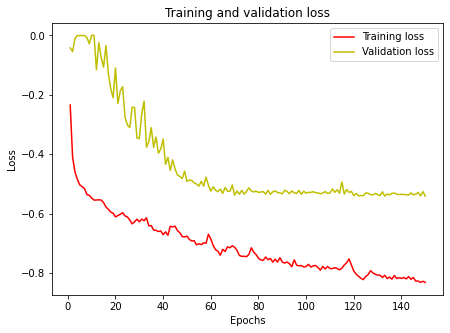

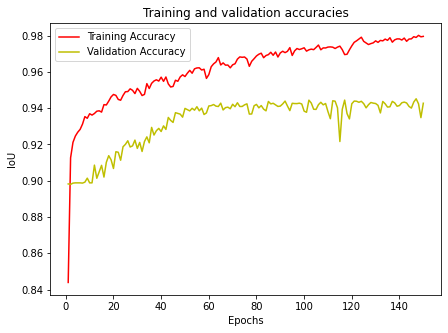

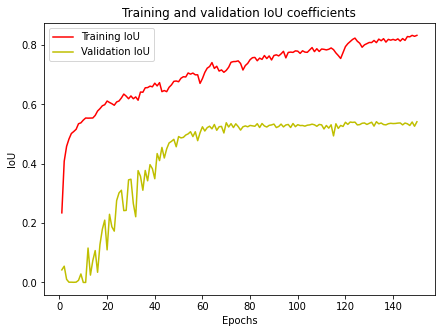

In [13]:
#training-validation loss curve
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(7,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training-validation accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(7,5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

#training-validation IoU curve
iou_coef = history.history['IoU_coef']
val_iou_coef = history.history['val_IoU_coef']
plt.figure(figsize=(7,5))
plt.plot(epochs, iou_coef, 'r', label='Training IoU')
plt.plot(epochs, val_iou_coef, 'y', label='Validation IoU')
plt.title('Training and validation IoU coefficients')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

1/1 [==============================] - 0s 65ms/step
Execution time:  0:00:00.630287


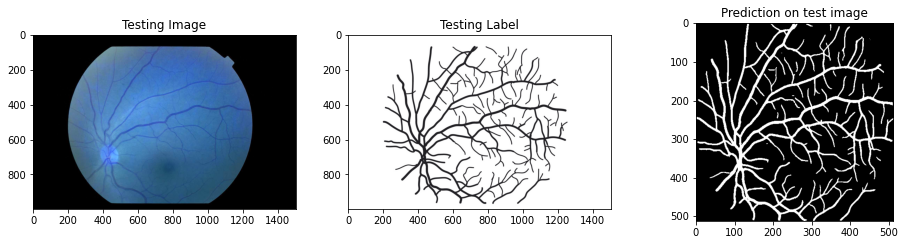

In [45]:
#prediction on single image
from datetime import datetime 
from google.colab.patches import cv2_imshow
from patchify import unpatchify

reconstructed_image = []
test_img = cv2.imread("/content/drive/MyDrive/AV_split/train/images/IM000001.JPG") #test image
gt = cv2.imread("/content/drive/MyDrive/AV_split/train/GT_vessel/IM000001--vessels.jpg") #test image

predicted_patches = []
start = datetime.now()   

test = image_aug(test_img, patch_size)
patches = patchify(test, (patch_size, patch_size), step=patch_size) 

for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
          single_patch = patches[i,j,:,:]
          single_patch_norm = (single_patch.astype('float32')) 
          single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
          single_patch_input = np.expand_dims(single_patch_norm, 0)
          single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8) #predict on single patch
          predicted_patches.append(single_patch_prediction)
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patch_size,patch_size) )
reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) #join patches to form whole img
reconstructed_image = cv2.resize(reconstructed_image, (512, 512))

stop = datetime.now()
print('Execution time: ',(stop-start)) #computation time

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(gt, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(reconstructed_image, cmap='gray')
